<a href="https://colab.research.google.com/github/lopesmatheus/COA19-PythonSimu/blob/main/PIE_Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL6 - Notebook Actor-Critic Algorithms

By Hedwin BONNAVAUD - hedwin.bonnavaud@isae.fr

 1. [Description](#description)
 2. [Prerequisites](#prerequisites)
 2. [Actor-critic](#actor_critic)
     1. [Deep Deterministic policy gradient](#ddpg)
     2. [Soft-Actor Critic](#sac)

## Description
<div id="description"></div>

In the reinforcement basics notebook, you saw how an actor critic architecture can be used to learn an optimal policy in a given environment. This architecture is also mandatory when we want to do reinforcement learning in a continuous actions action space environment, and we are going to see why latter. Our goal in this notebook, is to implement two of the most famous actor-critic algorithms, DDPG and SAC, to solve continuous action space environments. 

## Prerequisites

### Environments

First, let's introduce the environments we are going to use.

#### [Pendulum-v0](https://gym.openai.com/envs/Pendulum-v0/)

Here, the agent controll the force applied on the pendulum. The pendulum cannot move, but it can rotate aroud it's axis. His rotation speed depend on the force applied by the agent.

The state of the cos and sin of the rotating part angle, and his angle.

The action space is obviously continuous. In other work, this is a continuous and simpler (even if in general, continuous mean harder) version on the swing up environment we saw at the last class.

In [29]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 37.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 80.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [175]:
import gym
import numpy as np
import time


### Agents

To simplify the global code of this notebook, I propose you tho use a mother class for each of our agents. This will allow us to build a simulation function that take in argument an environment and an agent, and work with any agents and any environments. Then all you will have to do is to describe what the agent should do at each step of the learning.

I give you here this class, with the replay buffer from RL5 notebook, and an implementation of DQN that follow ou main Agent structure.

In [168]:
import random
import torch
from torch import nn
from statistics import mean
import matplotlib.pyplot as plt
import copy

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    def __init__(self, capacity, device=DEVICE):
        self.capacity = capacity # capacity of the buffer
        self.device = device
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(x).to(self.device), list(zip(*batch))))

    def __len__(self):
        return len(self.data)

class Agent:
    """
    An global agent class that describe the interactions between our agent and it's environment
    """
    def __init__(self, state_space, action_space, device=DEVICE, name="base_agent"):

        self.name = name  # The name is used inside plot legend, outputs directory path, and outputs file names

        self.state_space = state_space
        self.state_shape = state_space.shape
        self.state_size = state_space.shape[0]  # Assume state space is continuous

        self.continuous = isinstance(action_space, gym.spaces.Box)
        self.action_space = action_space
        self.nb_actions = self.action_space.shape[0] if self.continuous else self.action_space.n
        self.last_state = None  # Useful to store interaction when we recieve (new_stare, reward, done) tuple
        self.device = device
        self.episode_id = 0
        self.episode_time_step_id = 0
        self.time_step_id = 0
    
    def on_simulation_start(self):
        """
        Called when an episode is started. will be used by child class.
        """
        pass
    
    def on_episode_start(self, state):
        self.last_state = state
        self.episode_time_step_id = 0
        self.episode_id = 0

    def action(self, state):
        res = self.action_space.sample()
        return res

    def on_action_stop(self, action, new_state, reward, done):
        self.episode_time_step_id += 1
        self.time_step_id += 1
        self.last_state = new_state

    def on_episode_stop(self):
        self.episode_id += 1

    def on_simulation_stop(self):
        pass


# Now we can define our DQN using Agent class
class DQNAgent(Agent):
    """
    An agent that learn an approximated Q-Function using a neural network. 
    This Q-Function is used to find the best action to execute in a given state. 
    """
    def __init__(self, state_space, action_space, name="DQN",
                gamma=0.95, epsilon_min=0.01, epsilon_max=1., epsilon_decay_period=1000, epsilon_decay_delay=20,
                buffer_size=1000000, learning_rate=0.001, update_target_freq=100, batch_size=20,
                layer_1_size=50, layer_2_size=50, nb_gradient_steps=1):
        
        assert isinstance(action_space, gym.spaces.Discrete)  # Make sure our action space is discrete
        super().__init__(state_space, action_space, name=name)
        
        self.gamma = gamma
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon_decay_delay = epsilon_decay_delay
        
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.update_target_freq = update_target_freq
        self.nb_gradient_steps = nb_gradient_steps
        
        self.epsilon_step = (epsilon_max - self.epsilon_min) / epsilon_decay_period
        self.total_steps = 0
        self.model = torch.nn.Sequential(nn.Linear(self.state_size, layer_1_size),
                          nn.ReLU(),
                          nn.Linear(layer_1_size, layer_2_size),
                          nn.ReLU(), 
                          nn.Linear(layer_2_size, self.nb_actions)).to(self.device)
        
        self.criterion = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.target_model = copy.deepcopy(self.model).to(self.device)
        self.update_target_freq = update_target_freq
    
    def on_simulation_start(self):
        self.epsilon = self.epsilon_max
    
    def action(self, state):
        if self.time_step_id > self.epsilon_decay_delay:                
            self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_step)
        
        if np.random.rand() < self.epsilon:  # Epsilon greedy
            action = np.random.randint(self.nb_actions)
        else:
            # greedy_action(self.model, state) function in RL5 notebook
            with torch.no_grad():
                Q = self.model(torch.Tensor(state).unsqueeze(0).to(self.device))
                action = torch.argmax(Q).item()
        return action

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done)
        self.learn()
        super().on_action_stop(action, new_state, reward, done)  # Repale self.last_state by the new_state
    def learn(self):
        for _ in range(self.nb_gradient_steps):
            # gradient_step() function in RL5 notebook
            if len(self.replay_buffer) > self.batch_size:
                states, actions, rewards, new_states, dones = self.replay_buffer.sample(self.batch_size)
                Q_new_state_max = self.target_model(new_states).max(1)[0].detach()
                update = torch.addcmul(rewards, self.gamma, 1 - dones, Q_new_state_max)
                Q_s_a = self.model(states).gather(1, actions.to(torch.long).unsqueeze(1))
                loss = self.criterion(Q_s_a, update.unsqueeze(1))
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        
        # update target network if needed
        if self.time_step_id % self.update_target_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())

Now let's build a function that run a simulation where a given agent interact with a givent environment. 

In [169]:
def simulation(environment, agent, nb_episodes=200, verbose=True):
    episodes_rewards_sum = []
    agent.on_simulation_start()
    for episode_id in range(nb_episodes):
        state = environment.reset()
        agent.on_episode_start(state)

        episode_rewards = []
        done = False
        while not done:
            action = agent.action(state)
            state, reward, done = environment.step(action)

            # Ending time step process ...
            agent.on_action_stop(action, state, reward, done)

            # Store reward
            episode_rewards.append(reward)
        agent.on_episode_stop()
        rewards_sum = sum(episode_rewards)
        episodes_rewards_sum.append(rewards_sum)
        #environment.close()
        if len(episodes_rewards_sum) > 20:
            last_20_average = mean(episodes_rewards_sum[-20:])
        else:
            last_20_average = mean(episodes_rewards_sum)

        if verbose:
            print("Episode ", '{:3d}'.format(episode_id),
                  ", episode return ", '{:4.1f}'.format(rewards_sum),
                  ", last 20 avg ", '{:4.1f}'.format(last_20_average),
                  sep='')
    return episodes_rewards_sum

## Actor-critic

<div id="actor_critic"></div>

As we saw earlier in this class, Deep Q-Network (DQN) was made for discrete actions spaces. 
It use a Q-network, that is made to give the expected value of each action in a given state.
In continuous action space, this algorithm cannot be used because we cannot allocate one neural-network output for each action. 
To correct this problem, the main idea is to make the Q-Network return a single outpur, that will be the value of the state action pair, that is given in input. But do this prevent us to choose the action, and that's why we add another neural network called the actor, taking a state as the input, and returning the value of each continuous action to take (1 action between -1 and 1 for pendulum, so 1 neuron at the output, 2 for lunar lander).

To train this neural network, we just have to use the Q-Network, to estimate how much the chosen action is good to take in the given state.

This is the main idea around actor critic architecture. To understand in detail how it work, YOU are going to implement two of the most known off-policy actor critic architectures, Deep-Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC). 

As in other notebook, the code of these two algorithms are given. But because the number of questions/task to do is low in this notebook compared to others, I hardly recomend you to code them by yourself first. Try to run them, and if it's not working well, try some improvement or to understand what is not working, before to give up and look the solution. You will have the entire session to implement 2 algorithms, so take your time to make sure you understood them well.

### Deep-Deterministic Policy Gradient (DDPG)

<div id="ddpg"></div>

DDPG is considered as an off-policy algorithm, because the policy used to train the critic is different than the one used to generate samples.

For the general idea, when we select an interaction (s, a, r, s', a') to train our critic network, the way a' will be chosen will define the reward propagation (generally called credit assignment) speed. If a' is the optimal action from s', like in DQN, there is a high probability to get an action that lead in interestig and highly valuated states s''. In that case, the high values and the rewards will be propagated to (s, a) value, more frequently than s'' with low value.

In SARSA case, the a' actions will be chose following GLIE actor (cf RL1 - RL fundamentals notebook), that will depend on an exploration strategy, so a' can be random sometime. When a' is random, we have a high probability to evaluate Q'(s', a') where action a' is a bad action in state s'. In this case, Q(s, a) will also be learned as being a bad action state pair, even if s' can maybe lead to an interesting reward. We call SARSA an on-policy algorithm. For a purely actor-critic on-policy algorithm, you can also check [A3C](https://arxiv.org/pdf/1602.01783.pdf) but you don't need to understand this algorithm in this notebook.

If you didn't got it, you can also check this course from Olivier SIGAUD on youtube : https://youtu.be/hlhzvQnXdAA

Now, I want you to implement DDPG algorithm, that use an actor network, a critic network, and two target networks for both actor and critic to respectively compute a' and Q'.

Note that the default DDPG algorithm don't use epsilon-greedy, but add a noise on the action to make it explore. The original paper use a OU-noise, but for simplicity, we will generate a gaussian noise N(mean, std) to noise our action.

To make sure you know how to implement it, let's answer to some questions:

<div class="alert alert-warning">
If we have an actor network A, a critic actor network A' and a state s, how will I compute actions a to build samples when my agent is interacting with it's environment ? How will I compute action a' to compute Q'(s', a') to train my critic network ?
<div/>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>
When the agent is generating training samples while interacting with it's environment, he need to explore it to find new interesting states. In this case, the choosen action will be 

    a = A(s) + noise
    
When the agent is generations next_action a' to train critic by computing Q'(s', a'), we don't want him to explore so the generated a' have a higher probability to correspond to a highly valuable Q'(s', a'), so this value have a higher change to be propagated to Q(s, a), speeding up the training.
<details/>

<div class="alert alert-warning">
If the critic is used to evaluate the action a taken by the actor network in a given state s. What will be the loss of the critic network ?
<div/>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>
In this situation, the critic is learning a Q-value, like the DQN model is doing. For this reason, the loss of our critic network should be similar:
    
    # Pseudo code
    target = reward + gamma * (1 - done) * target_critic(s', a')
    critic_loss = MSE(critic(s, a), target)
<details/>

<div class="alert alert-warning">
If the critic is able to evaluate an action a, taken by the actor network in a state s, what should be the actor loss ? (do not search for something to complicated, the answer is simple! :)
<div/>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>
Note that if we are learning a sample s, a, r, s', d from the buffer, only s can be used in the actor training. In fact, the action chosen by the actor at time step t, will not obviously be the same than the action taken by actor at time step t - n, when the sample was generated in the environment (because the actor is learning at every time step). For this reason, a, r, s', d and no more re-usable for the actor.

    a = actor(s)
    loss_actor = -critic(s, a)

Note that the actor nedd the critic to be trained befor he can learn. In some way, the actor ability is trained to make shure the agent is going in states that satisfy the critic. Generally, in the learn() function, we train the critic before the actor, but is just speed-up the learning by 1 time step so it's not mandatory.
<details/>

#### Performances

You shouldn't be worry if your DDPG training is long. In my experiments, the learning took 100 episodes to get a sum of reawards around -700 in average, and 200 episodes to converge between -200 and -400 with the following attributes:

 - Env: Pendulum-v0
 - Noise: mean=0, std=0.1
 - actor_learning_rate=0.000025
 - critic_learning_rate=0.00025, 
 - gamma=0.99,  # Discount factor
 - buffer_max_size=1000000, 
 - layer1_size=200, # For both critic and actor
 - layer2_size=150, # For both critic and actor
 - batch_size=64,  # For both critic and actor
 - tau=0.01,
 
The last parameter tau is to update target networks. At each time steps, I update the weights of target networks to be a weighted average between their weights, and the targeted network weights :

    target_model_weight = target_model_weight * (1 - tau) + model_weight * tau
    
This is another way to update target critic and target actor, but the one you learned in RL5 notebook (copy weights every n time steps) should also work.

Here I give you an architecture for both actor and critic neural networks. The Sequential function we used before should work, but the learning in continuous action space is really long, and use LayerNorm layers increase so much learning speed, so you will gain time on your notebook. Initialise weights as I do here increase a bit more the learning speed, but according to my experience the impact is not really increadible.

[WARN] I also recommand to use torch.tanh activation function on the last layer of the actor since it increase the learning.

I can't explain why all of these increase the learning speed, I just observed it guided by some tips found on internet ... Everithing you should understand and remember here, is why the default architecture and behaviour of DDPG make the learning converge.

In [170]:
from torch import optim

def init_weights(layer, bound=None):
    if bound is None:
        bound = 1. / np.sqrt(layer.weight.data.size()[0])
    torch.nn.init.uniform_(layer.weight.data, -bound, bound)
    torch.nn.init.uniform_(layer.bias.data, -bound, bound)


class DefaultNN(nn.Module):
    def __init__(self, learning_rate, input_dims, layer_1_dims, layer_2_dims, output_dims, device,
                 last_activation=None):
        super().__init__()
        self.last_activation = last_activation
        self.layer_1 = nn.Linear(input_dims, layer_1_dims)
        init_weights(self.layer_1)
        self.layer_norm_1 = nn.LayerNorm(layer_1_dims)

        self.layer_2 = nn.Linear(layer_1_dims, layer_2_dims)
        init_weights(self.layer_2)
        self.layer_norm_2 = nn.LayerNorm(layer_2_dims)

        self.layer_3 = nn.Linear(layer_2_dims, output_dims)
        init_weights(self.layer_3, bound=0.003)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.device = device
        self.to(self.device)

    def forward(self, inputs):
        running_output = self.layer_1(inputs)
        running_output = self.layer_norm_1(running_output)
        running_output = torch.nn.functional.relu(running_output)
        running_output = self.layer_2(running_output)
        running_output = self.layer_norm_2(running_output)
        running_output = torch.nn.functional.relu(running_output)
        running_output = self.layer_3(running_output)

        if self.last_activation is not None:
            running_output = self.last_activation(running_output)
        return running_output

    def converge_to(self, other_model, tau=0.01):
        """
        Make the value of parameters of this model converge to one from the given model.
        The parameter tau indicate how close our weights should be from the one of the other model.
        self.converge_to(other_model, tau=1) is equivalent to self = copy.deepcopy(other_model).

        other_model should have the same shape, dimensions, than self.
        """
        for self_param, other_param in zip(self.parameters(), other_model.parameters()):
            self_param.data.copy_(
                self_param.data * (1.0 - tau) + other_param.data * tau
            )

In [176]:
import numpy as np
from scipy.integrate import odeint

class CarPend:
    def __init__(self,max_time=400):
        self.M = 400/1000
        self.m = 50/1000
        self.action_space = gym.spaces.Box(-5.0,5.0,(1,),np.float64)
        self.observation_space=gym.spaces.Box(np.array([-5.0,-10.0,-2.0*np.pi,-10.0]),np.array([5.0,10.0,2.0*np.pi,10.0]),(4,),np.float64)
        self.dt = 0.01
        self.count=0
        self.L = 0.3
        
        self.x = 0
        self.xp = 0
        self.xpp = 0
        
        self.theta = 0
        self.thetap = 0
        self.thetapp = 0
        self.max_time=max_time
        
    def reset(self):
        self.x = 0
        self.xp = 0
        self.count=0
        self.theta = np.random.uniform(-np.pi/100., np.pi/100.)
        self.thetap = 0#np.random.uniform(-0.1,0.1)

        state = [self.x,self.xp,self.theta,self.thetap]
        return np.array(state)

    def dynamic_mod(self,x0,t,f):
        x1,x2,x3,x4 = x0
        tol = 10**(-6)
        er = 1
        g = 9.81
        b = 0.01
        
        dx2dt_old = self.xpp
        dx4dt_old = self.thetapp
        
        while er>tol:
            if abs(x1)>=5:
                dx2dt = 0
            else:
                dx2dt = (f - dx4dt_old * self.m * self.L * np.cos(x3) + self.m * self.L * (x4**2) * np.sin(x3)) / (self.M + self.m)
            
            dx4dt = (self.m * g * self.L * np.sin(x3) - self.m * self.L * np.cos(x3) * dx2dt - b*x4) / (self.m * self.L**2)
            
            er = max(abs(dx2dt - dx2dt_old),abs(dx4dt - dx4dt_old))
            
            dx2dt_old = dx2dt
            dx4dt_old = dx4dt
        
        self.xpp = dx2dt
        self.thetapp = dx4dt
        return np.array([float(x2),float(dx2dt),float(x4),float(dx4dt)])
    
    def step(self,action):
        done=False
        self.count+=1
        x0 = np.array([self.x,self.xp,self.theta,self.thetap])
        t=np.array([0,self.dt])
        self.action=action
        
        #print(self.action.dtype)
        sol = odeint(self.dynamic_mod,x0,t,args=(self.action,))
        
        self.x = sol[-1,0]
        self.x = max(self.x,-5)
        self.x = min(self.x, 5)
        
        if abs(self.x)>=5:
            self.xp = 0
        else:
            self.xp = sol[-1,1]
        
        self.theta = sol[-1,2]
        self.thetap = sol[-1,3]
        
        state = [self.x,self.xp,self.theta,self.thetap]
        
        if abs(self.x)<=2.5 and abs(self.theta)<=50*np.pi/180:
            done = False
            #reward = 1
            
        else:
            done = True
            #reward = 0

        reward=-100*self.theta**2 
        
        if self.count>=self.max_time:
          done=True
            
        return np.array(state), reward, done,_

In [177]:
def simulation(environment, agent, nb_episodes=200, verbose=True):
    episodes_rewards_sum = []
    agent.on_simulation_start()
    for episode_id in range(nb_episodes):
        state = environment.reset()
        agent.on_episode_start(state)

        episode_rewards = []
        done = False
        while not done:
            action = agent.action(state)
            state, reward, done ,_= environment.step(action)
            # Ending time step process ...
            agent.on_action_stop(action, state, reward, done)

            # Store reward
            episode_rewards.append(reward)
        agent.on_episode_stop()
        rewards_sum = sum(episode_rewards)
        episodes_rewards_sum.append(rewards_sum)
        #environment.close()
        if len(episodes_rewards_sum) > 20:
            last_20_average = mean(episodes_rewards_sum[-20:])
        else:
            last_20_average = mean(episodes_rewards_sum)

        if verbose:
            print("Episode ", '{:3d}'.format(episode_id),
                  ", episode return ", '{:4.1f}'.format(rewards_sum),
                  ", last 20 avg ", '{:4.1f}'.format(last_20_average),
                  sep='')
    return episodes_rewards_sum

In [178]:
# %load solutions/RL6_DDPG.py
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

### NEW indicate the differences between DQN and DDPG.
class DDPGAgent(Agent):
    def __init__(self, state_space, action_space, device, actor_lr=0.000025, critic_lr=0.00025, tau=0.001, gamma=0.99,
                 max_size=100000, layer1_size=200, layer2_size=150, batch_size=64, noise_std=0.1, name="DDPG"):
        assert isinstance(action_space, gym.spaces.Box)  ### NEW: The action space is now continuous 
        super().__init__(state_space, action_space, device=device, name=name)
        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(max_size, self.device)
        self.batch_size = batch_size

        self.actor = DefaultNN(actor_lr, self.state_size, layer1_size, layer2_size, self.nb_actions
                               , self.device,
                               last_activation=None)
        self.critic = DefaultNN(critic_lr, self.state_size + self.nb_actions, layer1_size, layer2_size, 1, self.device)

        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)

        self.normal_distribution = torch.distributions.normal.Normal(
            torch.zeros(self.nb_actions), torch.full((self.nb_actions,), noise_std))

    def action(self, observation):
        with torch.no_grad():
            observation = torch.tensor(observation, dtype=torch.float).to(self.device)
            actor_output = self.actor.forward(observation).to(self.device)
            #action=torch.normal(actor_output[0], np.abs(actor_output[1]))
            noise = self.normal_distribution.sample()
            action = actor_output + noise
        return action.cpu().detach().numpy()

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done)
        self.learn()
        super().on_action_stop(action, new_state, reward, done)

    def learn(self):
        #if len(self.replay_buffer) > self.batch_size:
        if len(self.replay_buffer.data) > self.batch_size:
            states, actions, rewards, new_states, dones = self.replay_buffer.sample(self.batch_size)

            with torch.no_grad():
                target_actions = self.target_actor.forward(new_states)
                critic_value_ = self.target_critic.forward(torch.concat((new_states, target_actions), dim=-1))
            critic_value = self.critic.forward(torch.concat((states, actions), dim=-1))
            target = torch.addcmul(rewards, self.gamma, 1 - dones, critic_value_.squeeze()).view(self.batch_size, 1)
            self.critic.optimizer.zero_grad()
            critic_loss = torch.nn.functional.mse_loss(target, critic_value)
            critic_loss.backward()
            self.critic.optimizer.step()

            self.actor.optimizer.zero_grad()
            actions = self.actor.forward(states)
            actor_loss = - self.critic.forward(torch.concat((states, actions), dim=-1))
            actor_loss = torch.mean(actor_loss)
            actor_loss.backward()
            self.actor.optimizer.step()

            self.target_critic.converge_to(self.critic, tau=self.tau)
            self.target_actor.converge_to(self.actor, tau=self.tau)

# Test our agent on Pendulum-v0
#environment = gym.make('Pendulum-v1')
environment = CarPend()
agent = DDPGAgent(environment.observation_space, environment.action_space, device=DEVICE)


Episode   0, episode return -846.8, last 20 avg -846.8
Episode   1, episode return -791.6, last 20 avg -819.2
Episode   2, episode return -766.9, last 20 avg -801.8
Episode   3, episode return -766.7, last 20 avg -793.0
Episode   4, episode return -691.0, last 20 avg -772.6


KeyboardInterrupt: ignored

In [144]:

torch.save(agent.actor.state_dict(), 'act_checkpoint.pth')
#agent.critic.save('act_checkpoint.pth')
torch.save(agent.critic.state_dict(), 'crit_checkpoint.pth')

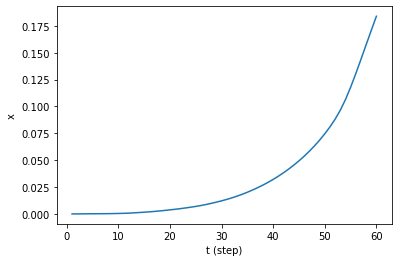

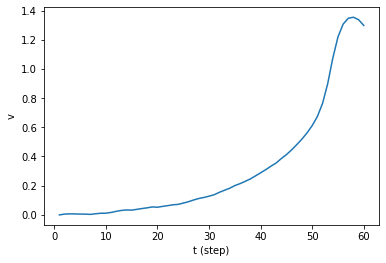

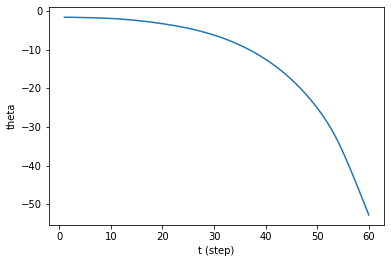

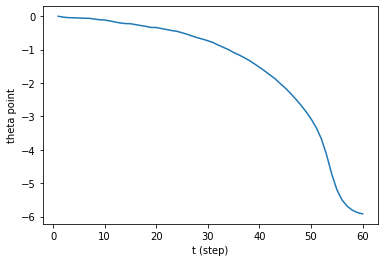

In [165]:
# There. we finished
# Lets see it in action
cartpole=CarPend()
done = False
cnt = 0
observation = cartpole.reset()
t=[]
x=[]
xp=[]
th=[]
thp=[]
while not done :
    cnt += 1
    t.append(cnt)

    action = agent.action(observation)
    observation, reward, done,_ = cartpole.step(action)
    x.append(observation[0])
    xp.append(observation[1])
    th.append(observation[2])
    thp.append(observation[3])



    # Lets see how long it lasts until failing


plt.figure()
plt.plot(t,x)
plt.xlabel('t (step)')
plt.ylabel('x')

plt.figure()
plt.plot(t,xp)
plt.xlabel('t (step)')
plt.ylabel('v')

plt.figure()
plt.plot(t,np.array(th)*180/np.pi)
plt.xlabel('t (step)')
plt.ylabel('theta')

plt.figure()
plt.plot(t,thp)
plt.xlabel('t (step)')
plt.ylabel('theta point')
#plt.figure()
#plt.plot(t,xpp)

plt.show()

### Soft Actor-critic (SAC)

<div id="sac"></div>

Soft Actor-Critic is really close to DDPG, except that it learn using a regularised entropy on actions policy.

#### Shanon entropy

Let X be a random variable with a law of density p(X) satisfying the normalization and positivity requirements, we define its entropy by
$$-\int_{X} p(x) log (p(x))$$

It allows to quantify the disorder of a random variable. The entropy is maximal when X follows an uniform distribution, and minimal when p(X) is equal to zero everywhere except in one value, which is a Dirac distribution.

#### Why entropy in SAC?

In SAC algorithm, we not only consider the critic evaluation inside the actor loss, but also it's decision entropy.
The loss of the agent should be high when the entropy is low, because it will invite him to explore more.
The mode the entropy of the agent is important, the more it will explore.

More, SAC use entropy to estimate next_states value. The more the entropy of the target actor is important while choosing a', the more s' will be condidered as highly valuable.
To illustrate the intiution behing this, let's imagine an environment with a discrete state space, in a sigle line: 


|    |    |    |
|:--:|:--:|:--:|
| +1 | A  | +1 |

In the exemple above, the agent (A) will recieve a reward of +1 at the next round, whatever the next action he will chose. Because the actor loss make him maximise critig grade and entropy, he will improve entropy when the critig grage cannot be improved anymore. In this case, the critic value will everytime be the same, whatever the action taken by the agent. For this reason, the action entropy will be maximize, so the agent will have the same probability to go in any directions.

This fact bring a side effect. Because states are consider good when the entropy of the action taken from them is high, the agent will maintain itself in states where he will be sake whatever the next taken action. This behavior is also present in DDPG but is strengten here but the entropy maximisation, making our agent gain in stability (you will observe the gap in performances standard deviation latter).


|    |    |    |
|:--:|:--:|:--:|
| -1 | A  | +1 |

In this new case, the entropy of the action will be low because the actor loss will be lower if the critic evaluation is high, so he should choose deterministic action that leads to states with the higher value.

In other words, we can say that SAC will perform a better exploration/exploitation trade-off, by takin both the advantage of a high exploration, and the advantage of a high exploitation. He will maximize exploration by mawimising entropy, but will not suffer from the incovenient of high exploration that is fall in bad state and never enstrenght the optimal trajectory the the best rewards, because he will fly away from bad rewarding states.


#### How to use entropy in SAC?

To compute an entropy, we need the actor to give use a random distribution. The most common way to archieve that, is to make the actor with 2 * nb_action outputs neurons, giving actions means and standard deviations.

Because the standart deviation, it is common to make the actor return the log(std), and then get the real std with $e^{log_std}$. But we can also put the std output inside a relu().

To get the action, we can sample actions from the means and standard deviations we got. Doing this will prevent us latter to retro-propagate the gradient when we will train our actor, so we should do a reparametrization trick when we want to compute actions for actor training (more explanation in the code to fill bellow).
Sample with reparametrisation is equivalent to compute $a = \mu + \mathcal{N}(0,\,1)\ * sigma$.

In general, for a given a', we maximise entropy my minimising $log (p(x))$. Looking at the entropy function, we can understand that $log(p(x))$ have a higher impact than p(x) only, because p(x) is between 0 and 1, and $|log(p(x))|$ is generally extremly high because p(x) is generally close to 0.

Because our environment action space is bounded, but our normal distribution is not, we can put the actions we got inside tanh function to get some between -1 and 1, and then scale it to our environment action space. Because we bould our actions, we should do a process over our log prob as follow:

        log_probs = actions_distribution.log_prob(actions)
        log_probs -= torch.log(1 - action.pow(2) + self.min_std)
        log_probs = log_probs.sum(dim=-1)
        
We are not going deeper about these mathematicals details, but if you are interested, the explanation if this is in [SAC paper](https://arxiv.org/pdf/1812.05905.pdf), appendic C (bottom of page 16).

Now you should have any informations to complete the code bellow for SAC implementation! To gain some time, wome code parts are already filled.

NB: Algorithm hyperparameters are given in $__init__$ function, the new alpha hyper parameter is the ratio between Q value and entropy inside critic update:
$$V(s') = TargetCritic(s', a') - alpha * LogProb$$ where $$a', LogProg = SampleAction(s')$$

Note that SAC is very stable and converge well, so you don't neet to have low learning rate and you also can use a Sequential() model (like we did with DQN) without LayerNorm layers inside.

In [ ]:
class SACAgent(Agent):
    def __init__(self, state_space, action_space, device, actor_lr=0.001, critic_lr=0.001, gamma=0.98, 
                 max_size=10000, tau=0.005, layer1_size=128, layer2_size=128, batch_size=128, alpha=0.9):
        super().__init__(state_space, action_space, device, "SAC")
        # TODO
        pass
    
    def converge_to(self, model, other_model, tau=None):
        """
        Make the first model weights converge to the second one with a ration of tau.
        """
        if tau is None:
            tau = self.tau
        for self_param, other_param in zip(model.parameters(), other_model.parameters()):
            self_param.data.copy_(
                self_param.data * (1.0 - tau) + other_param.data * tau
            )

    def sample_action(self, state, reparameterize=False, actor_network=None):
        if actor_network is None:
            actor_network = self.actor
        # TODO
        # 1. Sample an action from the given state using the given actor network. It can be the target or the 
        #    default actor depending on when this function is called
        # 2. raparameterize is used to performed a reparametrisation trick if we want to keep the gradient 
        #    to retro-propagate it later. Use reparametrize=True when you call this function to train the actor.
        #    if it is True, sample action using distribution.rsampl(), use sample() otherwise.
        # 3. Compute the log_probability as explained in SAC description
        # 4. Return both the actions taken and the log probabilities
        pass

    def action(self, state):
        actions, _ = self.sample_action(state, reparameterize=False)
        return actions.cpu().detach().numpy()

    def learn(self):
        if len(self.replay_buffer) > self.batch_size:
            states, actions, rewards, next_states, done = self.replay_buffer.sample(self.batch_size)

            # Training critic
            # TODO

            # Train actor
            # TODO

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done)
        self.learn()
        super().on_action_stop(action, new_state, reward, done)

# Test our agent on LunarLanderContinuous-v2  (Don't work on Pendulum because of an unexpected bug)
environment = gym.make("LunarLanderContinuous-v2")
nb_seeds = 4
sac_seeds_result = []
ddpg_seeds_result = []
for seed_id in range(nb_seeds):
    
    print()
    print("###################")
    print()
    print("      SEED " + str(seed_id))
    print()
    print("###################")
    
    print()
    print(" > Training SAC")
    print()
    agent = SACAgent(environment.observation_space, environment.action_space, device=DEVICE)
    sac_seeds_result.append(simulation(environment, agent, nb_episodes=80))
    
    print()
    print(" > Training DDPG")
    print()
    agent = DDPGAgent(environment.observation_space, environment.action_space, device=DEVICE)
    ddpg_seeds_result.append(simulation(environment, agent, nb_episodes=80))

    sac_means = np.mean(np.array(sac_seeds_result), axis=0)
    sac_stds = np.std(np.array(sac_seeds_result), axis=0)

    ddpg_means = np.mean(np.array(ddpg_seeds_result), axis=0)
    ddpg_stds = np.std(np.array(ddpg_seeds_result), axis=0)

    plt.cla()
    plt.plot(sac_means, color="g", label="sac")
    plt.fill_between([x for x in range(len(sac_means))], sac_means + sac_stds, sac_means - sac_stds, color="g", alpha=0.2)
    plt.plot(ddpg_means, color="r", label="ddpg")
    plt.fill_between([x for x in range(len(ddpg_means))], ddpg_means + ddpg_stds, ddpg_means - ddpg_stds, color="b", alpha=0.2)
    plt.legend()
    plt.show()


###################

      SEED 0

###################

 > Training SAC

Episode   0, episode return -144.5, last 20 avg -144.5
Episode   1, episode return -109.8, last 20 avg -127.1
Episode   2, episode return -351.3, last 20 avg -201.9
Episode   3, episode return -465.2, last 20 avg -267.7
Episode   4, episode return -117.7, last 20 avg -237.7
Episode   5, episode return -167.4, last 20 avg -226.0
Episode   6, episode return -64.5, last 20 avg -202.9
Episode   7, episode return -80.4, last 20 avg -187.6
Episode   8, episode return -211.0, last 20 avg -190.2
Episode   9, episode return -311.9, last 20 avg -202.4
Episode  10, episode return -237.8, last 20 avg -205.6
Episode  11, episode return -79.5, last 20 avg -195.1
Episode  12, episode return -125.7, last 20 avg -189.7
Episode  13, episode return -150.5, last 20 avg -186.9
Episode  14, episode return -63.1, last 20 avg -178.7
Episode  15, episode return -122.7, last 20 avg -175.2
Episode  16, episode return -56.4, last 20 avg -16

Episode  71, episode return -264.7, last 20 avg -207.6
Episode  72, episode return -68.4, last 20 avg -177.3
Episode  73, episode return -84.1, last 20 avg -175.8
Episode  74, episode return -214.5, last 20 avg -155.2
Episode  75, episode return 22.4, last 20 avg -137.7
Episode  76, episode return -54.8, last 20 avg -132.3
Episode  77, episode return -50.2, last 20 avg -120.1
Episode  78, episode return -247.2, last 20 avg -119.7
Episode  79, episode return -36.2, last 20 avg -107.5


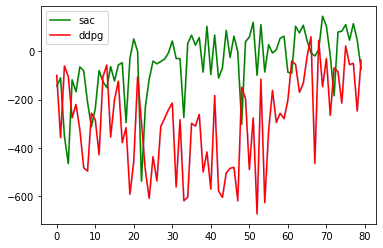


###################

      SEED 1

###################

 > Training SAC

Episode   0, episode return -108.4, last 20 avg -108.4
Episode   1, episode return -229.2, last 20 avg -168.8
Episode   2, episode return -229.1, last 20 avg -188.9
Episode   3, episode return -325.3, last 20 avg -223.0
Episode   4, episode return -93.3, last 20 avg -197.1
Episode   5, episode return -256.0, last 20 avg -206.9
Episode   6, episode return -205.8, last 20 avg -206.7
Episode   7, episode return -121.3, last 20 avg -196.1
Episode   8, episode return -79.7, last 20 avg -183.1
Episode   9, episode return -218.5, last 20 avg -186.7
Episode  10, episode return -5.5, last 20 avg -170.2
Episode  11, episode return -252.0, last 20 avg -177.0
Episode  12, episode return -400.1, last 20 avg -194.2
Episode  13, episode return -594.3, last 20 avg -222.7
Episode  14, episode return -343.1, last 20 avg -230.8
Episode  15, episode return -251.7, last 20 avg -232.1
Episode  16, episode return -299.6, last 20 avg -2

Episode  70, episode return 175.3, last 20 avg -204.8
Episode  71, episode return -393.3, last 20 avg -211.6
Episode  72, episode return -194.5, last 20 avg -206.9
Episode  73, episode return -494.3, last 20 avg -209.5
Episode  74, episode return -110.6, last 20 avg -203.4
Episode  75, episode return -425.1, last 20 avg -217.3
Episode  76, episode return -336.1, last 20 avg -225.2
Episode  77, episode return -489.9, last 20 avg -241.4
Episode  78, episode return -55.7, last 20 avg -236.0
Episode  79, episode return -30.7, last 20 avg -228.9


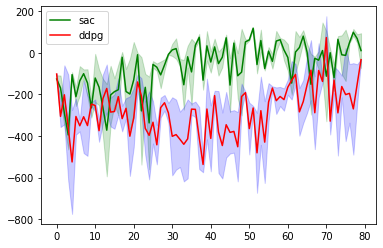


###################

      SEED 2

###################

 > Training SAC

Episode   0, episode return -313.2, last 20 avg -313.2
Episode   1, episode return -6.4, last 20 avg -159.8
Episode   2, episode return -398.5, last 20 avg -239.4
Episode   3, episode return -121.9, last 20 avg -210.0
Episode   4, episode return -121.8, last 20 avg -192.4
Episode   5, episode return -332.4, last 20 avg -215.7
Episode   6, episode return -292.9, last 20 avg -226.7
Episode   7, episode return -182.2, last 20 avg -221.2
Episode   8, episode return -257.5, last 20 avg -225.2
Episode   9, episode return -360.9, last 20 avg -238.8
Episode  10, episode return -144.6, last 20 avg -230.2
Episode  11, episode return -132.0, last 20 avg -222.0
Episode  12, episode return -306.3, last 20 avg -228.5
Episode  13, episode return -188.1, last 20 avg -225.6
Episode  14, episode return -333.7, last 20 avg -232.8
Episode  15, episode return -208.6, last 20 avg -231.3
Episode  16, episode return -86.0, last 20 avg -

Episode  70, episode return -239.2, last 20 avg -260.5
Episode  71, episode return -275.5, last 20 avg -255.6
Episode  72, episode return -275.6, last 20 avg -258.1
Episode  73, episode return -271.6, last 20 avg -256.0
Episode  74, episode return -228.4, last 20 avg -241.4
Episode  75, episode return -239.5, last 20 avg -230.9
Episode  76, episode return -214.9, last 20 avg -220.4
Episode  77, episode return -215.1, last 20 avg -231.3
Episode  78, episode return -103.1, last 20 avg -219.1
Episode  79, episode return -121.2, last 20 avg -207.7


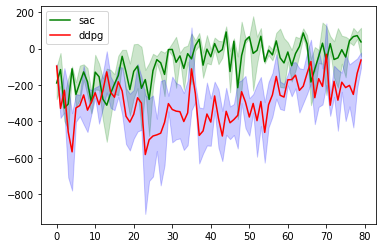


###################

      SEED 3

###################

 > Training SAC

Episode   0, episode return -109.0, last 20 avg -109.0
Episode   1, episode return -159.7, last 20 avg -134.3
Episode   2, episode return -198.0, last 20 avg -155.5
Episode   3, episode return -589.5, last 20 avg -264.0
Episode   4, episode return -214.3, last 20 avg -254.1
Episode   5, episode return -302.4, last 20 avg -262.1
Episode   6, episode return -407.2, last 20 avg -282.9
Episode   7, episode return -255.6, last 20 avg -279.4
Episode   8, episode return -260.2, last 20 avg -277.3
Episode   9, episode return -215.3, last 20 avg -271.1
Episode  10, episode return -161.4, last 20 avg -261.1
Episode  11, episode return -185.9, last 20 avg -254.9
Episode  12, episode return -226.7, last 20 avg -252.7
Episode  13, episode return -227.0, last 20 avg -250.9
Episode  14, episode return -31.2, last 20 avg -236.2
Episode  15, episode return -23.7, last 20 avg -222.9
Episode  16, episode return -60.8, last 20 avg -

Episode  71, episode return 32.8, last 20 avg -234.9
Episode  72, episode return -350.2, last 20 avg -251.1
Episode  73, episode return -187.5, last 20 avg -246.9
Episode  74, episode return -16.2, last 20 avg -238.7
Episode  75, episode return -272.5, last 20 avg -238.9
Episode  76, episode return -171.6, last 20 avg -233.9
Episode  77, episode return -202.4, last 20 avg -230.4
Episode  78, episode return -316.7, last 20 avg -233.4
Episode  79, episode return -260.4, last 20 avg -233.8


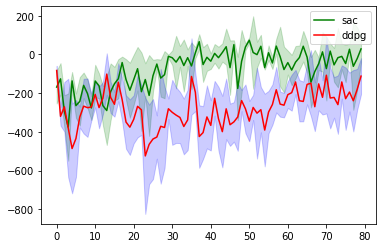

In [ ]:
# %load solutions/RL6_SAC.py
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

from torch import optim
import torch.nn.functional as f
from torch.distributions.normal import Normal

class SACAgent(Agent):
    def __init__(self, state_space, action_space, device, actor_lr=0.001, critic_lr=0.001, gamma=0.98,
                 max_size=1000000, tau=0.005, layer1_size=128, layer2_size=128, batch_size=128, alpha=1):
        super().__init__(state_space, action_space, device, "SAC")
        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(max_size, self.device)
        self.batch_size = batch_size

        self.actions_bounds_range = torch.tensor((action_space.high[0] - action_space.low[0]) / 2).to(self.device)
        self.actions_bounds_mean = torch.tensor(mean((action_space.high[0], action_space.low[0]))).to(self.device)
        self.min_std = 1e-6

        self.actor = nn.Sequential(nn.Linear(self.state_size, layer1_size), nn.ReLU(),
                                   nn.Linear(layer1_size, layer2_size), nn.ReLU(),
                                   nn.Linear(layer2_size, 2 * self.nb_actions)).to(device=self.device).float()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.target_actor = copy.deepcopy(self.actor)

        self.critic = nn.Sequential(nn.Linear(self.state_size + self.nb_actions, layer1_size), nn.ReLU(),
                                    nn.Linear(layer1_size, layer2_size), nn.ReLU(),
                                    nn.Linear(layer2_size, 1)).to(device=self.device).float()
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.target_critic = copy.deepcopy(self.critic)

        self.alpha = alpha
    
    def converge_to(self, model, other_model, tau=None):
        if tau is None:
            tau = self.tau
        for self_param, other_param in zip(model.parameters(), other_model.parameters()):
            self_param.data.copy_(
                self_param.data * (1.0 - tau) + other_param.data * tau
            )

    def sample_action(self, state, reparameterize=False, actor_network=None):
        if actor_network is None:
            actor_network = self.actor

        # Forward
        if isinstance(state, np.ndarray):
            state = torch.from_numpy(state).to(self.device)

        actor_output = actor_network(state)

        if len(state.shape) > 1:  # It's a batch
            actions_means = actor_output[:, :self.nb_actions]
            actions_stds = actor_output[:, self.nb_actions:]
        else:
            actions_means = actor_output[:self.nb_actions]
            actions_stds = actor_output[self.nb_actions:]

        actions_stds = torch.clamp(actions_stds, min=self.min_std, max=1)

        actions_distribution = Normal(actions_means, actions_stds)

        if reparameterize:
            actions = actions_distribution.rsample()
        else:
            actions = actions_distribution.sample()
        
        action = torch.tanh(actions) * self.actions_bounds_range + self.actions_bounds_mean
        log_probs = actions_distribution.log_prob(actions)
        log_probs -= torch.log(1 - action.pow(2) + self.min_std)
        log_probs = log_probs.sum(dim=-1)

        return action, log_probs

    def action(self, state):
        actions, _ = self.sample_action(state, reparameterize=False)

        return actions.cpu().detach().numpy()

    def learn(self):
        if len(self.replay_buffer) > self.batch_size:
            states, actions, rewards, next_states, done = self.replay_buffer.sample(self.batch_size)

            # Training critic
            with torch.no_grad():
                next_actions, next_log_probs = self.sample_action(next_states, actor_network=self.target_actor)
                next_q_values = self.target_critic.forward(torch.cat((next_states, next_actions), -1)).view(-1)

            q_hat = rewards + self.gamma * (1 - done) * (next_q_values - self.alpha * next_log_probs)
            self.critic_optimizer.zero_grad()
            q_values = self.critic.forward(torch.cat((states, actions), 1)).view(-1)
            critic_loss = f.mse_loss(q_values, q_hat)
            critic_loss.backward()
            self.critic_optimizer.step()
            
            self.converge_to(self.target_critic, self.critic)

            # Train actor
            actions, log_probs = self.sample_action(states, reparameterize=True)
            log_probs = log_probs.view(-1)
            critic_values = self.critic.forward(torch.cat((states, actions), -1)).view(-1)

            actor_loss = log_probs - critic_values
            actor_loss = torch.mean(actor_loss)
            self.actor_optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            self.actor_optimizer.step()
            
            self.converge_to(self.target_actor, self.actor)

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done)
        self.learn()
        super().on_action_stop(action, new_state, reward, done)

# Test our agent on LunarLanderContinuous-v2
environment = gym.make("LunarLanderContinuous-v2")
nb_seeds = 4
sac_seeds_result = []
ddpg_seeds_result = []
for seed_id in range(nb_seeds):
    
    print()
    print("###################")
    print()
    print("      SEED " + str(seed_id))
    print()
    print("###################")
    
    print()
    print(" > Training SAC")
    print()
    agent = SACAgent(environment.observation_space, environment.action_space, device=DEVICE)
    sac_seeds_result.append(simulation(environment, agent, nb_episodes=80))
    
    print()
    print(" > Training DDPG")
    print()
    agent = DDPGAgent(environment.observation_space, environment.action_space, device=DEVICE)
    ddpg_seeds_result.append(simulation(environment, agent, nb_episodes=80))

    sac_means = np.mean(np.array(sac_seeds_result), axis=0)
    sac_stds = np.std(np.array(sac_seeds_result), axis=0)

    ddpg_means = np.mean(np.array(ddpg_seeds_result), axis=0)
    ddpg_stds = np.std(np.array(ddpg_seeds_result), axis=0)

    plt.cla()
    plt.plot(sac_means, color="g", label="sac")
    plt.fill_between([x for x in range(len(sac_means))], sac_means + sac_stds, sac_means - sac_stds, color="g", alpha=0.2)
    plt.plot(ddpg_means, color="r", label="ddpg")
    plt.fill_between([x for x in range(len(ddpg_means))], ddpg_means + ddpg_stds, ddpg_means - ddpg_stds, color="b", alpha=0.2)
    plt.legend()
    plt.show()

Now you can see that entropy regularisation improve so much DDPG performances.

You don't need to remeber every performance improvement tricks we used in this notebook, but you should understand how DDPG and SAC works, and what are the differences between them, and between DQN and them.